In [1]:
pip install osmnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.8/102.8 kB 933.1 kB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import os
import networkx as nx
import pandas as pd
import collections
import itertools
import numpy as np
import random
import math
from sklearn.neighbors import BallTree
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from tqdm.notebook import tqdm

In [4]:
def compute_redundancy_index(graph):
    """
    Compute the redundancy index of a NetworkX graph.

    Parameters:
    graph (NetworkX graph): The input graph.

    Returns:
    float: The redundancy index of the graph.
    """
    # Number of edges or links
    e = graph.number_of_edges()

    # Number of vertices or nodes
    v = graph.number_of_nodes()

    # Number of strongly connected components for directed graph
    g = nx.number_strongly_connected_components(graph)

    # Calculate redundancy index
    redundancy_index = (e - v + g) / (((v**2 - v) / 2) - v + 1)

    return redundancy_index


def compute_max_cycles(graph):
    """
    Compute the maximum number of independent cycles in a NetworkX graph.

    Parameters:
    graph (NetworkX graph): The input graph.

    Returns:
    int: The maximum number of independent cycles for the graph.
    """
    # Number of nodes
    v = graph.number_of_nodes()

    # Calculate Max.Cycles
    max_cycles = ((v**2 - v) / 2) - (v - 1)

    return max_cycles


def compute_cyclomatic_number_directed(graph):
    """
    Compute the Cyclomatic Number of a directed NetworkX graph.

    Parameters:
    graph (NetworkX DiGraph): The input directed graph.

    Returns:
    int: The Cyclomatic Number of the graph.
    """
    # Actual number of links (edges)
    e = graph.number_of_edges()

    # Number of nodes
    v = graph.number_of_nodes()

    # Number of strongly connected components
    p = nx.number_strongly_connected_components(graph)

    # Cyclomatic number calculation for directed graph
    cyclomatic_number = e - v + p

    return cyclomatic_number


def compute_gamma_index(graph):
    """
    Compute the Gamma Index of a NetworkX graph.

    Parameters:
    graph (NetworkX graph): The input graph.

    Returns:
    float: The Gamma Index of the graph.
    """
    # Actual number of links (edges)
    e = graph.number_of_edges()

    # Number of nodes
    v = graph.number_of_nodes()

    # Maximum possible number of links for undirected graph
    e_max = 3 * (v - 2)

    # Gamma index
    gamma_index = e / e_max

    return gamma_index




In [5]:
place_name = 'Chicago,IL,USA'

streets_graph = ox.graph_from_place(place_name, network_type='drive')
streets_graph = ox.projection.project_graph(streets_graph)
scG = ox.utils_graph.get_largest_component(streets_graph, strongly=True)


In [6]:
stats = ox.basic_stats(scG)


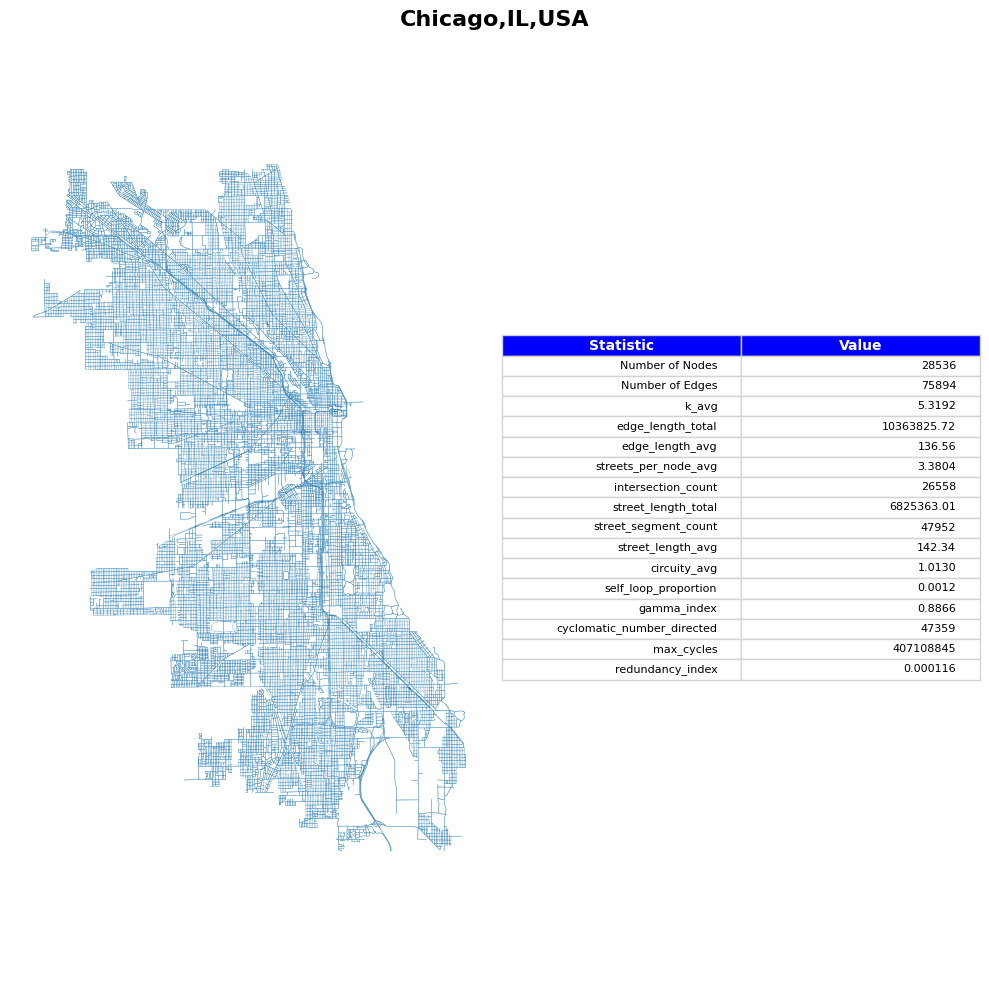

In [7]:
# Compute the additional measures
gamma_index_value = compute_gamma_index(scG)
cyclomatic_number_value_directed = compute_cyclomatic_number_directed(scG)
max_cycles_value = compute_max_cycles(scG)
redundancy_index_value = compute_redundancy_index(scG)

# Assuming 'scG' is your street network graph and 'stats' is your statistics dictionary
# Exclude specific keys from the stats
keys_to_exclude = ['streets_per_node_counts', 'streets_per_node_proportions', 'n', 'm']
filtered_stats = {key: stats[key] for key in stats if key not in keys_to_exclude}

# Add the computed values to the stats
filtered_stats['gamma_index'] = gamma_index_value
filtered_stats['cyclomatic_number_directed'] = cyclomatic_number_value_directed
filtered_stats['max_cycles'] = max_cycles_value  # This will be formatted as integer later
filtered_stats['redundancy_index'] = redundancy_index_value

# Prepare data for the table, placing number of nodes and edges at the top
table_data = [
    ['Number of Nodes', len(scG.nodes)],
    ['Number of Edges', len(scG.edges)]
]

# Custom formatting for specific values
for key, value in filtered_stats.items():
    if key == 'redundancy_index':
        formatted_value = f'{value:.6f}'  # 6 decimal places for redundancy_index
    elif key in ['street_length_total', 'edge_length_total', 'edge_length_avg', 'street_length_avg']:
        formatted_value = f'{value:.2f}'  # 2 decimal places for length and average values
    elif key == 'max_cycles':
        formatted_value = int(value)  # Convert to integer for max_cycles
    elif key in ['k_avg', 'streets_per_node_avg', 'circuity_avg', 'self_loop_proportion', 'gamma_index']:
        formatted_value = f'{value:.4f}'  # 4 decimal places for specified measures
    else:
        formatted_value = value  # Keep original value if it doesn't match any criteria

    table_data.append([key, formatted_value])


# Create a figure with two subplots, adjust the size as needed
fig, (ax_graph, ax_table) = plt.subplots(1, 2, figsize=(10, 10))

# Plot the graph in the first subplot
edges = ox.graph_to_gdfs(scG, nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)
edges.plot(ax=ax_graph, linewidth=0.2)
ax_graph.set_axis_off()

# Create a table in the second subplot
table = ax_table.table(cellText=table_data, colLabels=['Statistic', 'Value'], loc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)  # Adjust font size as needed

# Set the header style with bold text
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_fontsize(10)
        cell.set_facecolor('blue')
        cell.set_text_props(color='white', weight='bold')
    else:
        cell.set_edgecolor('lightgrey')

# Adjust cell borders
for cell in table.get_celld().values():
    cell.set_edgecolor('lightgrey')

ax_table.axis('off')  # Hide the axes

# Add the place name as the title for the entire figure
plt.suptitle(place_name, fontsize=16, fontweight='bold')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [8]:
degree_centrality = nx.degree_centrality(scG)

In [9]:
scaling_factor = 100  # Adjust as needed
node_size = [degree_centrality[node] * scaling_factor for node in scG.nodes()]

<ipython-input-10-419871575b62>:21: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat in dc_stats.iteritems():


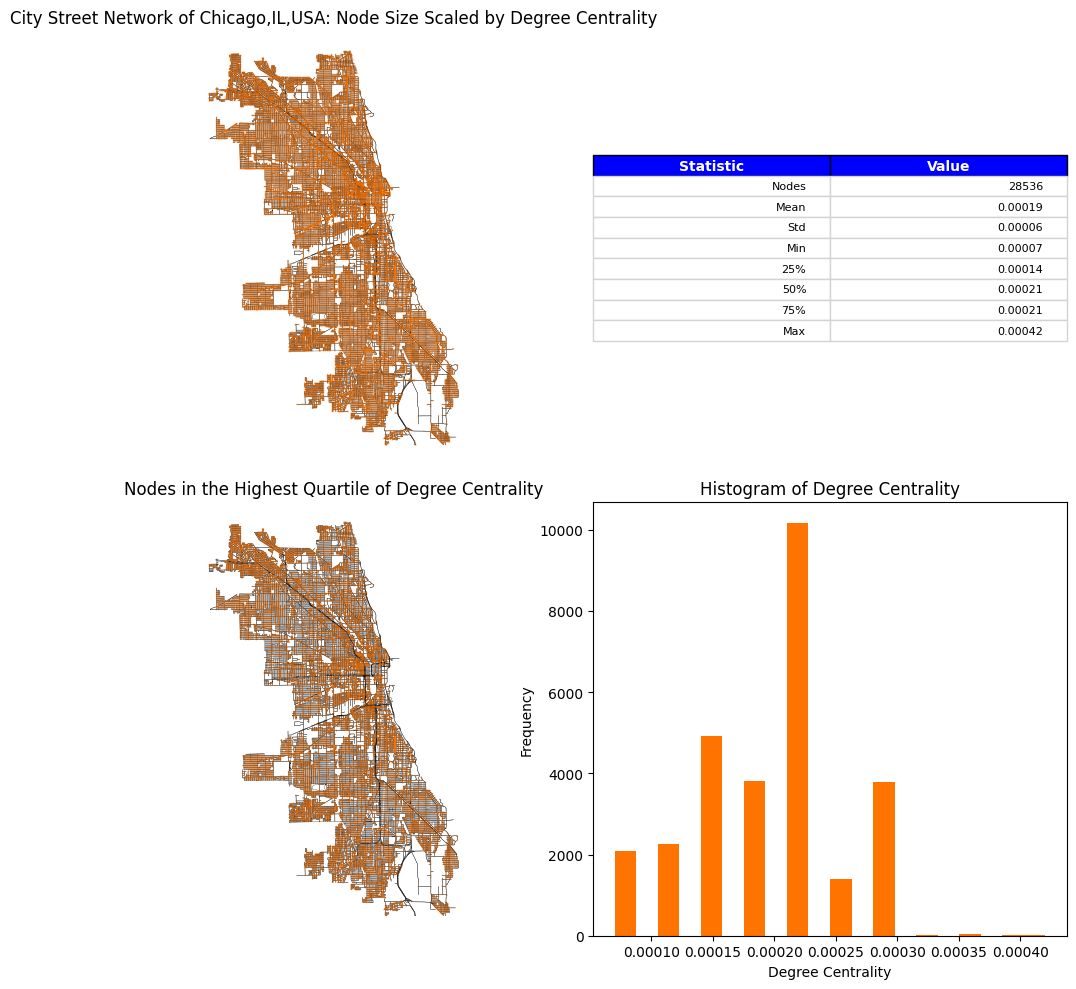

In [10]:
degree_centrality = nx.degree_centrality(scG)

scaling_factor = 100  # Adjust as needed
node_size = [degree_centrality[node] * scaling_factor for node in scG.nodes()]

# Convert degree centrality values to a Pandas Series and get descriptive statistics
dc_series = pd.Series(degree_centrality)
dc_stats = dc_series.describe()

pos = {node: (data['x'], data['y']) for node, data in scG.nodes(data=True)}


# Get the 75th percentile value of degree centrality
percentile_75th = dc_series.quantile(0.75)

# Prepare node sizes for the highest quartile
node_size_high_quartile = [degree_centrality[node] * scaling_factor if degree_centrality[node] >= percentile_75th else 0 for node in scG.nodes()]

# Prepare data for the table
table_data = []
for stat in dc_stats.iteritems():
    label = 'Nodes' if stat[0] == 'count' else stat[0].capitalize()
    formatted_value = f'{int(stat[1])}' if stat[0] == 'count' else f'{stat[1]:.5f}'
    table_data.append([label, formatted_value])

# Create a figure with four subplots
fig, ((ax_graph, ax_table), (ax_high_quartile, ax_histogram)) = plt.subplots(2, 2, figsize=(10, 10))

# Plot the graph in the first subplot
edges.plot(ax=ax_graph, linewidth=0.2, edgecolor='black')
nx.draw_networkx_nodes(scG, pos, node_size=node_size, node_color='#ff7300', ax=ax_graph)
ax_graph.set_axis_off()
ax_graph.set_title(f"City Street Network of {place_name}: Node Size Scaled by Degree Centrality")

# Plot only the highest quartile nodes in the second row, first subplot
edges.plot(ax=ax_high_quartile, linewidth=0.2, edgecolor='black')
nx.draw_networkx_nodes(scG, pos, node_size=node_size_high_quartile, node_color='#ff7300', ax=ax_high_quartile)
ax_high_quartile.set_axis_off()
ax_high_quartile.set_title("Nodes in the Highest Quartile of Degree Centrality")

# Plot the histogram in the second row, second subplot
ax_histogram.hist(dc_series, bins=20, color='#ff7300')
ax_histogram.set_title("Histogram of Degree Centrality")
ax_histogram.set_xlabel("Degree Centrality")
ax_histogram.set_ylabel("Frequency")

# Create a table in the first row, second subplot
table = ax_table.table(cellText=table_data, colLabels=['Statistic', 'Value'], loc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)

# Set the header style with bold text and blue background
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_fontsize(10)
        cell.set_facecolor('blue')
        cell.set_text_props(color='white', weight='bold')
    else:
        cell.set_edgecolor('lightgrey')

ax_table.axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [11]:
# Assuming 'scG' is your graph
subset_size = int(0.01 * scG.number_of_nodes())  # Adjust the percentage as needed
betweenness_centrality = nx.betweenness_centrality(scG, k=subset_size, normalized=True, seed=42)

# Prepare node size based on betweenness centrality
scaling_factor = 50  # Adjust as needed
node_size = [betweenness_centrality[node] * scaling_factor for node in scG.nodes()]


<ipython-input-12-5dcebdd82c82>:16: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat in bc_stats.iteritems():


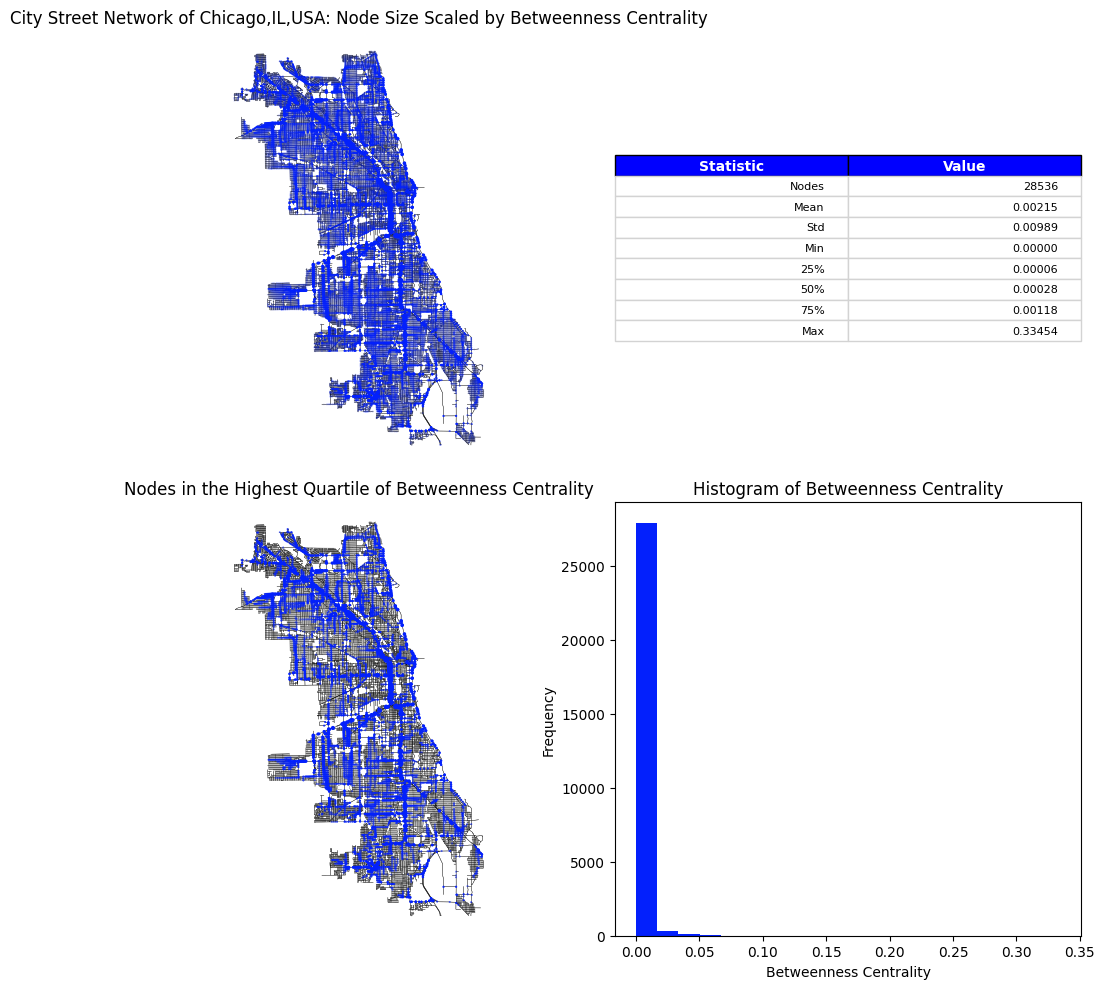

In [12]:
# Convert betweenness centrality values to a Pandas Series and get descriptive statistics
bc_series = pd.Series(betweenness_centrality)
bc_stats = bc_series.describe()

# Get positions of nodes in the graph
pos = {node: (data['x'], data['y']) for node, data in scG.nodes(data=True)}

# Get the 75th percentile value of betweenness centrality
percentile_75th = bc_series.quantile(0.75)

# Prepare node sizes for the highest quartile
node_size_high_quartile = [betweenness_centrality[node] * scaling_factor if betweenness_centrality[node] >= percentile_75th else 0 for node in scG.nodes()]

# Prepare data for the table
table_data = []
for stat in bc_stats.iteritems():
    label = 'Nodes' if stat[0] == 'count' else stat[0].capitalize()
    formatted_value = f'{int(stat[1])}' if stat[0] == 'count' else f'{stat[1]:.5f}'
    table_data.append([label, formatted_value])

# Create a figure with four subplots
fig, ((ax_graph, ax_table), (ax_high_quartile, ax_histogram)) = plt.subplots(2, 2, figsize=(10, 10))

# Plot the graph in the first subplot
edges = ox.graph_to_gdfs(scG, nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)
edges.plot(ax=ax_graph, linewidth=0.2, edgecolor='black')
nx.draw_networkx_nodes(scG, pos, node_size=node_size, node_color='#0320fc', ax=ax_graph)
ax_graph.set_axis_off()
ax_graph.set_title(f"City Street Network of {place_name}: Node Size Scaled by Betweenness Centrality")

# Plot only the highest quartile nodes in the second row, first subplot
edges.plot(ax=ax_high_quartile, linewidth=0.2, edgecolor='black')
nx.draw_networkx_nodes(scG, pos, node_size=node_size_high_quartile, node_color='#0320fc', ax=ax_high_quartile)
ax_high_quartile.set_axis_off()
ax_high_quartile.set_title("Nodes in the Highest Quartile of Betweenness Centrality")

# Plot the histogram in the second row, second subplot
ax_histogram.hist(bc_series, bins=20, color='#0320fc')
ax_histogram.set_title("Histogram of Betweenness Centrality")
ax_histogram.set_xlabel("Betweenness Centrality")
ax_histogram.set_ylabel("Frequency")

# Create a table in the first row, second subplot
table = ax_table.table(cellText=table_data, colLabels=['Statistic', 'Value'], loc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)

# Set the header style with bold text and blue background
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_fontsize(10)
        cell.set_facecolor('blue')
        cell.set_text_props(color='white', weight='bold')
    else:
        cell.set_edgecolor('lightgrey')

ax_table.axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [13]:
closeness_centrality = nx.closeness_centrality(scG)
# Prepare node size based on betweenness centrality
scaling_factor = 50  # Adjust as needed
node_size = [v * scaling_factor for v in closeness_centrality.values()]


<ipython-input-14-63b355204ed5>:14: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat in cc_stats.iteritems():


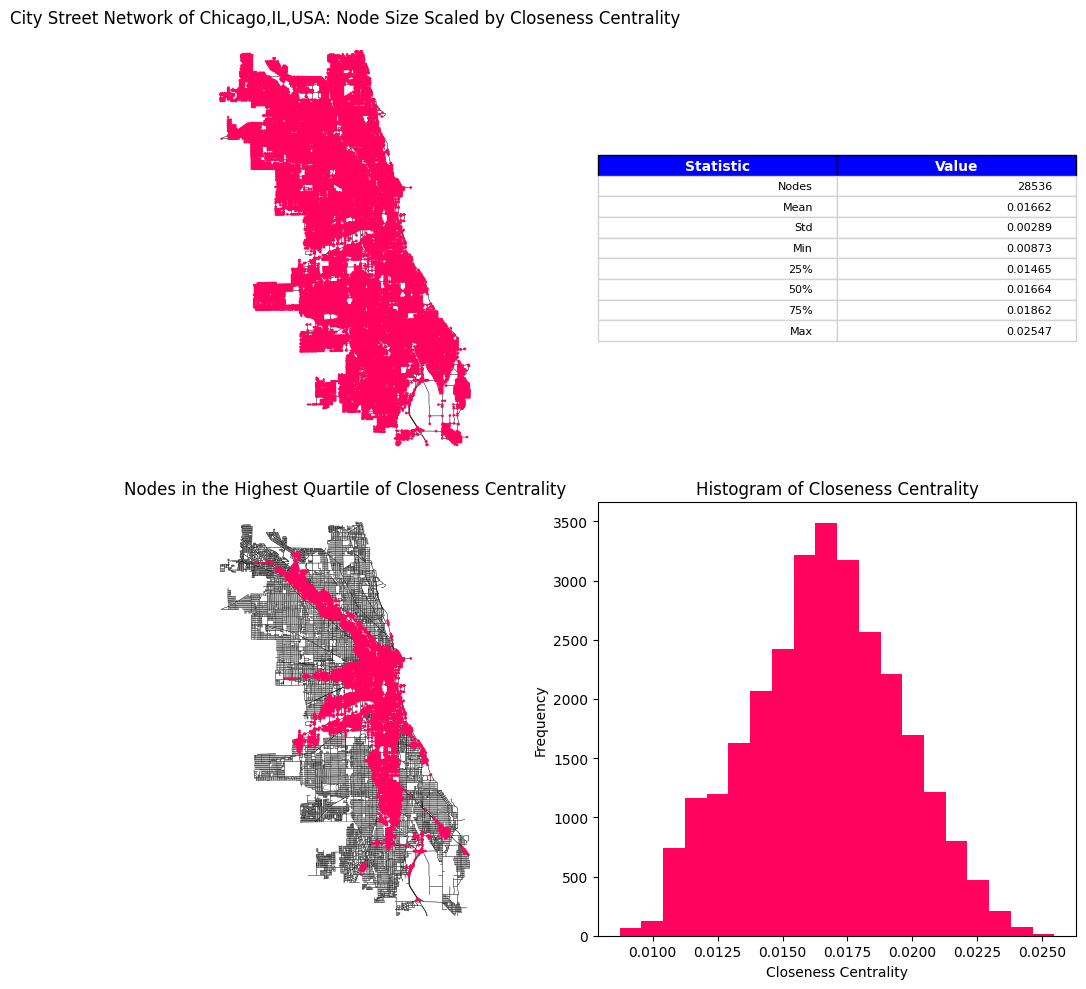

In [14]:

# Convert closeness centrality values to a Pandas Series and get descriptive statistics
cc_series = pd.Series(closeness_centrality)
cc_stats = cc_series.describe()


# Get the 75th percentile value of closeness centrality
percentile_75th = cc_series.quantile(0.75)

# Prepare node sizes for the highest quartile
node_size_high_quartile = [closeness_centrality[node] * scaling_factor if closeness_centrality[node] >= percentile_75th else 0 for node in scG.nodes()]

# Prepare data for the table
table_data = []
for stat in cc_stats.iteritems():
    label = 'Nodes' if stat[0] == 'count' else stat[0].capitalize()
    formatted_value = f'{int(stat[1])}' if stat[0] == 'count' else f'{stat[1]:.5f}'
    table_data.append([label, formatted_value])

# Create a figure with four subplots
fig, ((ax_graph, ax_table), (ax_high_quartile, ax_histogram)) = plt.subplots(2, 2, figsize=(10, 10))

# Get positions of nodes in the graph
pos = {node: (data['x'], data['y']) for node, data in scG.nodes(data=True)}

# Plot the graph in the first subplot
edges = ox.graph_to_gdfs(scG, nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)
edges.plot(ax=ax_graph, linewidth=0.2, edgecolor='black')
nx.draw_networkx_nodes(scG, pos, node_size=node_size, node_color='#ff035f', ax=ax_graph)
ax_graph.set_axis_off()
ax_graph.set_title(f"City Street Network of {place_name}: Node Size Scaled by Closeness Centrality")

# Plot only the highest quartile nodes in the second row, first subplot
edges.plot(ax=ax_high_quartile, linewidth=0.2, edgecolor='black')
nx.draw_networkx_nodes(scG, pos, node_size=node_size_high_quartile, node_color='#ff035f', ax=ax_high_quartile)
ax_high_quartile.set_axis_off()
ax_high_quartile.set_title("Nodes in the Highest Quartile of Closeness Centrality")

# Plot the histogram in the second row, second subplot
ax_histogram.hist(cc_series, bins=20, color='#ff035f')
ax_histogram.set_title("Histogram of Closeness Centrality")
ax_histogram.set_xlabel("Closeness Centrality")
ax_histogram.set_ylabel("Frequency")

# Create a table in the first row, second subplot
table = ax_table.table(cellText=table_data, colLabels=['Statistic', 'Value'], loc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)

# Set the header style with bold text and blue background
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_fontsize(10)
        cell.set_facecolor('blue')
        cell.set_text_props(color='white', weight='bold')
    else:
        cell.set_edgecolor('lightgrey')

ax_table.axis('off')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [15]:
# Assign centrality measures as attributes to each node
for node in scG.nodes():
    scG.nodes[node]['closeness_centrality'] = closeness_centrality[node]
    scG.nodes[node]['betweenness_centrality'] = betweenness_centrality[node]
    scG.nodes[node]['degree_centrality'] = degree_centrality[node]


In [16]:
# Create an empty list to store the centrality data for each node
centrality_data = []

# Iterate over each node and its data in the graph
for node, data in scG.nodes(data=True):
    # Extract centrality measures and other attributes as needed
    node_data = {
        'node_id': node,
        'closeness_centrality': data.get('closeness_centrality', 0),
        'betweenness_centrality': data.get('betweenness_centrality', 0),
        'degree_centrality': data.get('degree_centrality', 0)
        # Add other node attributes here if needed
    }
    centrality_data.append(node_data)

# Convert the list of dictionaries to a DataFrame
centrality_df = pd.DataFrame(centrality_data)

## KMEANS

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

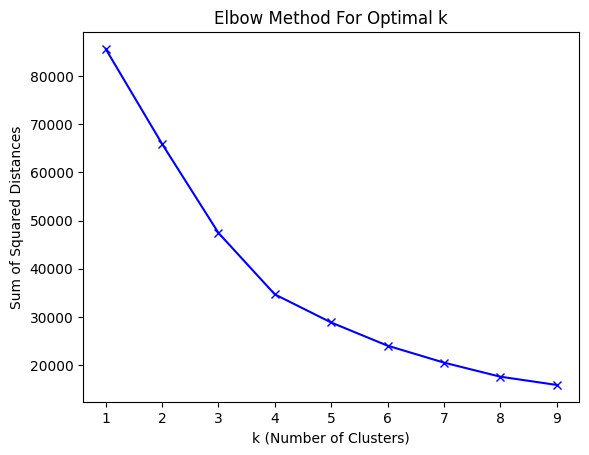

In [17]:
# Extracting the relevant features
features = centrality_df[['closeness_centrality', 'betweenness_centrality', 'degree_centrality']]

# Normalizing the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Calculating the sum of squared distances for different numbers of clusters (k)
sum_of_squared_distances = []
K = range(1, 10)  # Adjust the range as needed
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(features_scaled)
    sum_of_squared_distances.append(km.inertia_)

# Plotting the "elbow" graph
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k (Number of Clusters)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

# HERE STOP AND CHOOSE THE RIGH NUMBER OF CLUSTER

In [18]:
# Set node_id as the index for centrality_df
centrality_df.set_index('node_id', inplace=True)


kmeans = KMeans(n_clusters=4)
centrality_df['kmeans_cluster'] = kmeans.fit_predict(features_scaled)

# Define a custom set of distinct and brighter colors
custom_colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6']
num_clusters = kmeans.n_clusters
selected_colors = custom_colors[:num_clusters]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


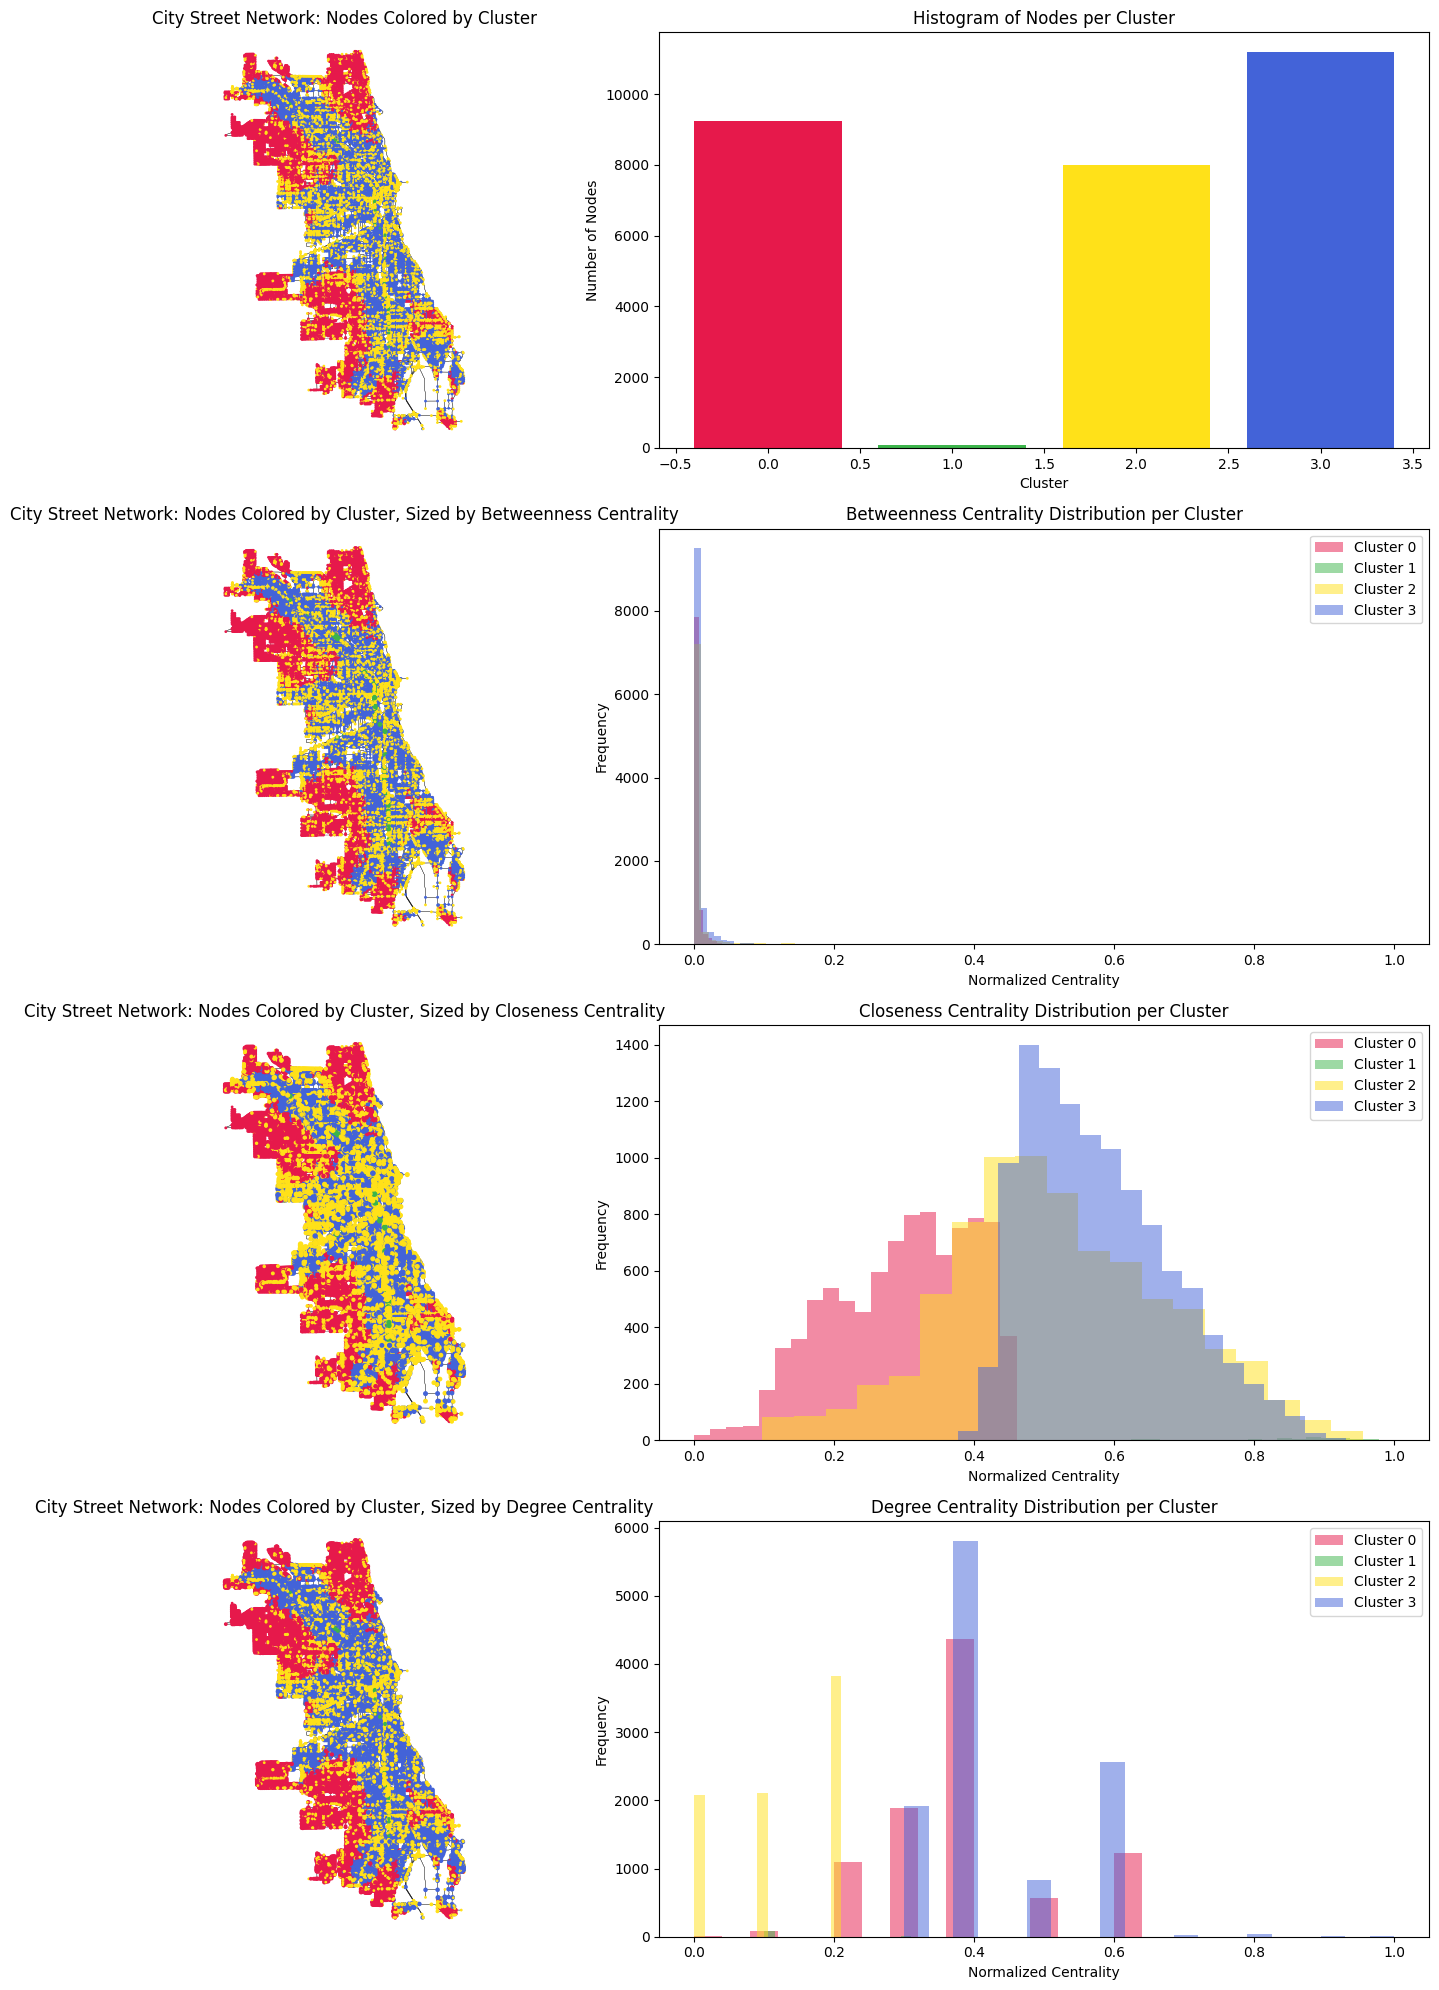

In [19]:
# Normalize the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(centrality_df[['closeness_centrality', 'betweenness_centrality', 'degree_centrality']])


# Normalize each centrality measure
centralities_norm = ['betweenness_centrality_norm', 'closeness_centrality_norm', 'degree_centrality_norm']
for centrality in centralities_norm:
    centrality_df[centrality] = (centrality_df[centrality.split('_norm')[0]] - centrality_df[centrality.split('_norm')[0]].min()) / (centrality_df[centrality.split('_norm')[0]].max() - centrality_df[centrality.split('_norm')[0]].min())

# Create a 4x2 grid for subplots
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten()  # Flatten the 2D array of axes

# Map the cluster assignments to custom colors
node_colors = [selected_colors[centrality_df.loc[node, 'kmeans_cluster']] if node in centrality_df.index else 'gray' for node in scG.nodes()]

# First row: Network graph colored by cluster
edges_gdf = ox.graph_to_gdfs(scG, nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)
edges_gdf.plot(ax=axes[0], linewidth=0.2, edgecolor='black')
nx.draw_networkx_nodes(scG, pos, node_color=node_colors, node_size=1, ax=axes[0])
axes[0].set_axis_off()
axes[0].set_title("City Street Network: Nodes Colored by Cluster")

# Histogram of nodes per cluster
cluster_counts = centrality_df['kmeans_cluster'].value_counts().sort_index()
for cluster in range(num_clusters):
    axes[1].bar(cluster, cluster_counts[cluster], color=selected_colors[cluster])
axes[1].set_title('Histogram of Nodes per Cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Number of Nodes')

# Subsequent rows: Network graphs colored by cluster and histograms of centrality distribution
for i, centrality_norm in enumerate(centralities_norm, 1):
    # Network graph
    node_sizes = 10 * centrality_df[centrality_norm] + 1  # Adjust size as needed
    edges_gdf.plot(ax=axes[2*i], linewidth=0.2, edgecolor='black')
    nx.draw_networkx_nodes(scG, pos, node_color=node_colors, node_size=node_sizes, ax=axes[2*i])
    axes[2*i].set_axis_off()
    axes[2*i].set_title(f"City Street Network: Nodes Colored by Cluster, Sized by {centrality_norm.split('_')[0].title()} Centrality")

    # Histogram of centrality distribution per cluster
    for cluster in range(num_clusters):
        cluster_data = centrality_df[centrality_df['kmeans_cluster'] == cluster][centrality_norm]
        axes[2*i+1].hist(cluster_data, bins=20, color=selected_colors[cluster], alpha=0.5, label=f'Cluster {cluster}')
    axes[2*i+1].set_title(f'{centrality_norm.split("_")[0].title()} Centrality Distribution per Cluster')
    axes[2*i+1].set_xlabel('Normalized Centrality')
    axes[2*i+1].set_ylabel('Frequency')
    axes[2*i+1].legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


## Incidenti

In [20]:
file_path = "/content/drive/My Drive/US_Accidents_March23.csv"
chunk_size = 10000

# Define the city and state from 'place_name'
city, state, _ = place_name.split(',')

# Columns of interest
columns_of_interest = ['Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Severity', 'City', 'County', 'State', 'Start_Time']

# Initialize an empty list to store the filtered chunks
filtered_chunks = []

# Read the file in chunks
with pd.read_csv(file_path, usecols=columns_of_interest, chunksize=chunk_size) as reader:
    for chunk in tqdm(reader):
        # Filter by city and state
        chunk_filtered = chunk[(chunk['City'].str.strip() == city.strip()) & (chunk['State'].str.strip() == state.strip())]
        if not chunk_filtered.empty:
            chunk_filtered['Start_Time'] = pd.to_datetime(chunk_filtered['Start_Time'])
            chunk_filtered['Start_Date'] = chunk_filtered['Start_Time'].dt.strftime('%Y-%m')
            filtered_chunks.append(chunk_filtered)

# Combine filtered chunks into a single DataFrame
filtered_city_df = pd.concat(filtered_chunks)

0it [00:00, ?it/s]

Output streaming troncato alle ultime 5000 righe.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_filtered['Start_Time'] = pd.to_datetime(chunk_filtered['Start_Time'])
<ipython-input-20-fc14b1cc6154>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk_filtered['Start_Date'] = chunk_filtered['Start_Time'].dt.strftime('%Y-%m')
<ipython-input-20-fc14b1cc6154>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

In [21]:
from pyproj import Transformer
import pandas as pd

def get_utm_zone(longitude):
    return int((longitude + 180) // 6) + 1

def apply_utm_conversion(df):
    transformers = {}
    for _, row in df.iterrows():
        if pd.notna(row['Start_Lat']) and pd.notna(row['Start_Lng']):
            utm_zone = get_utm_zone(row['Start_Lng'])

            if utm_zone not in transformers:
                transformers[utm_zone] = Transformer.from_crs(
                    "epsg:4326", f"epsg:326{utm_zone}", always_xy=True)

            transformer = transformers[utm_zone]
            x, y = transformer.transform(row['Start_Lng'], row['Start_Lat'])
            df.at[_, 'UTM_x'], df.at[_, 'UTM_y'] = x, y

# Apply the conversion to the filtered DataFrame
apply_utm_conversion(filtered_city_df)


In [22]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(scG)

# Calculate the average length of street segments
average_street_length = gdf_edges['length'].mean()
print(f"Average street length: {average_street_length} meters")

# Prepare the incidents data (ensure these are UTM coordinates)
incidents = filtered_city_df[['UTM_x', 'UTM_y']].to_numpy()

# Reset index of gdf_nodes to get a column with the original node identifiers
gdf_nodes = gdf_nodes.reset_index().rename(columns={'osmid': 'node_id'})

# Prepare the nodes data with the actual node identifiers
nodes = gdf_nodes[['x', 'y']].to_numpy()
node_ids = gdf_nodes['node_id'].to_numpy()

# Build a BallTree for efficient spatial queries (Euclidean distance for UTM coordinates)
tree = BallTree(nodes, metric='euclidean')

# Query the BallTree to find the nearest node to each incident and get the distances
distances, indices = tree.query(incidents, return_distance=True)
indices = indices.flatten()
distances = distances.flatten()  # distances are now in meters

# Initialize counters
assigned_accidents = 0
discarded_accidents = 0

# Map the positional indices back to the actual node identifiers and discard far accidents
for idx, (node_id, distance) in enumerate(zip(node_ids[indices], distances)):
    if distance <= average_street_length:
        scG.nodes[node_id]['accidents_per_node'] = scG.nodes[node_id].get('accidents_per_node', 0) + 1
        assigned_accidents += 1
    else:
        discarded_accidents += 1

# Print the counts of assigned and discarded accidents
print(f"Assigned accidents: {assigned_accidents}")
print(f"Discarded accidents: {discarded_accidents}")


Average street length: 136.55658836008118 meters
Assigned accidents: 30998
Discarded accidents: 1037


In [23]:
gdf_nodes, gdf_edges = ox.graph_to_gdfs(scG)

# Calculate the average length of street segments
average_street_length = gdf_edges['length'].mean()
print(f"Average street length: {average_street_length} meters")

# Prepare the incidents data (ensure these are UTM coordinates)
incidents = filtered_city_df[['UTM_x', 'UTM_y']].to_numpy()

# Reset index of gdf_nodes to get a column with the original node identifiers
gdf_nodes = gdf_nodes.reset_index().rename(columns={'osmid': 'node_id'})

# Prepare the nodes data with the actual node identifiers
nodes = gdf_nodes[['x', 'y']].to_numpy()
node_ids = gdf_nodes['node_id'].to_numpy()

# Build a BallTree for efficient spatial queries (Euclidean distance for UTM coordinates)
tree = BallTree(nodes, metric='euclidean')

# Query the BallTree to find the nearest node to each incident and get the distances
distances, indices = tree.query(incidents, return_distance=True)
indices = indices.flatten()
distances = distances.flatten()  # distances are now in meters

# Initialize counters and severity storage
assigned_accidents = 0
discarded_accidents = 0
total_severity_per_node = {}
accident_counts_per_node = {}

for idx, (node_id, distance) in enumerate(zip(node_ids[indices], distances)):
    if distance <= average_street_length:
        # Increment the accident count for this node
        accident_counts_per_node[node_id] = accident_counts_per_node.get(node_id, 0) + 1

        # Add the severity of this accident to the total severity for this node
        # Extract severity from the DataFrame
        accident_severity = filtered_city_df.iloc[idx]['Severity']
        total_severity_per_node[node_id] = total_severity_per_node.get(node_id, 0) + accident_severity

        assigned_accidents += 1
    else:
        discarded_accidents += 1

# Calculate the average severity for each node and assign it to the graph
for node_id in scG.nodes:
    if node_id in accident_counts_per_node:
        # Calculate average severity
        average_severity = total_severity_per_node[node_id] / accident_counts_per_node[node_id]
        scG.nodes[node_id]['average_severity'] = average_severity
    else:
        # If no accidents, set average severity to a default value (e.g., 0)
        scG.nodes[node_id]['average_severity'] = 0

# Print the counts of assigned and discarded accidents
print(f"Assigned accidents: {assigned_accidents}")
print(f"Discarded accidents: {discarded_accidents}")


Average street length: 136.55658836008118 meters
Assigned accidents: 30998
Discarded accidents: 1037


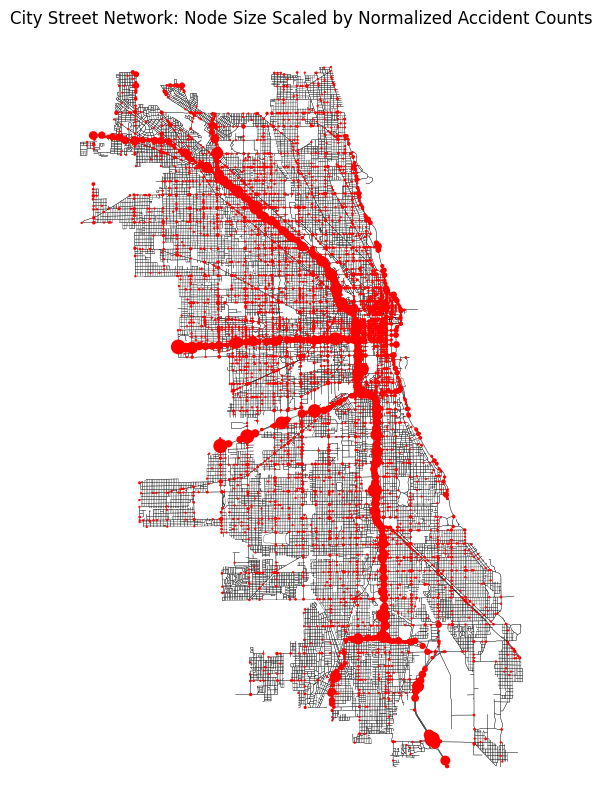

In [24]:
import matplotlib.pyplot as plt
import osmnx as ox

# Normalize the accident counts
max_accidents = max(data.get('accidents_per_node', 0) for _, data in scG.nodes(data=True))
scaling_factor = 100  # Adjust this factor to scale the node sizes

# Prepare node sizes based on normalized accident counts
node_sizes = [data.get('accidents_per_node', 0) / max_accidents * scaling_factor for _, data in scG.nodes(data=True)]

# Plotting
fig, ax = plt.subplots(figsize=(10, 10))
edges = ox.graph_to_gdfs(scG, nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)
edges.plot(ax=ax, linewidth=0.2, edgecolor='black')
nx.draw_networkx_nodes(scG, {node: (data['x'], data['y']) for node, data in scG.nodes(data=True)}, node_size=node_sizes, node_color='red', ax=ax)
ax.set_axis_off()
plt.title("City Street Network: Node Size Scaled by Normalized Accident Counts")
plt.show()


<ipython-input-25-1316c4d1daee>:24: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for label, value in apn_stats.iteritems()]


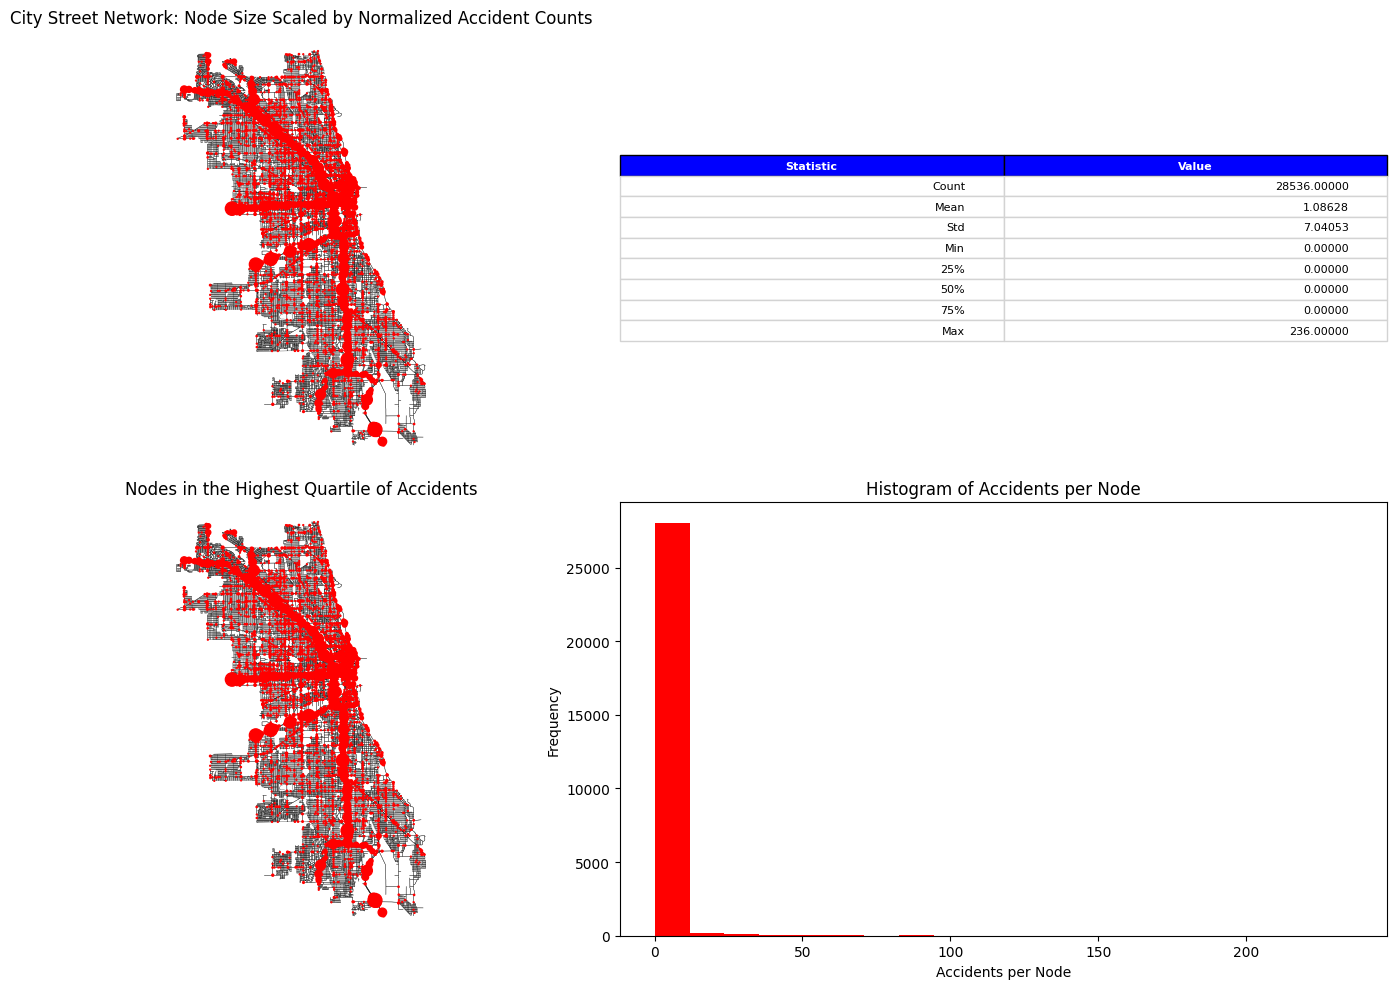

In [25]:
import matplotlib.pyplot as plt
import osmnx as ox
import networkx as nx
import pandas as pd

# Convert accidents per node to a Pandas Series
accidents_per_node = pd.Series({node: data.get('accidents_per_node', 0) for node, data in scG.nodes(data=True)})

# Normalize the number of accidents per node
max_accidents = accidents_per_node.max()
node_sizes = [100 * (accidents_per_node[node] / max_accidents) for node in scG.nodes()]

# Descriptive statistics for accidents per node
apn_stats = accidents_per_node.describe()

# Get the 75th percentile value
percentile_75th = accidents_per_node.quantile(0.75)

# Prepare node sizes for the highest quartile
node_size_high_quartile = [100 * (accidents_per_node[node] / max_accidents) if accidents_per_node[node] >= percentile_75th else 0 for node in scG.nodes()]

# Prepare data for the table
table_data = [[label.capitalize(), f'{value:.5f}' if isinstance(value, float) else value]
              for label, value in apn_stats.iteritems()]

# Create a figure with four subplots
fig, ((ax_graph, ax_table), (ax_high_quartile, ax_histogram)) = plt.subplots(2, 2, figsize=(15, 10))

# Plot the graph in the first subplot
edges = ox.graph_to_gdfs(scG, nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)
edges.plot(ax=ax_graph, linewidth=0.2, edgecolor='black')
nx.draw_networkx_nodes(scG, {node: (data['x'], data['y']) for node, data in scG.nodes(data=True)}, node_size=node_sizes, node_color='red', ax=ax_graph)
ax_graph.set_axis_off()
ax_graph.set_title("City Street Network: Node Size Scaled by Normalized Accident Counts")

# Plot only the highest quartile nodes in the second row, first subplot
edges.plot(ax=ax_high_quartile, linewidth=0.2, edgecolor='black')
nx.draw_networkx_nodes(scG, {node: (data['x'], data['y']) for node, data in scG.nodes(data=True)}, node_size=node_size_high_quartile, node_color='red', ax=ax_high_quartile)
ax_high_quartile.set_axis_off()
ax_high_quartile.set_title("Nodes in the Highest Quartile of Accidents")

# Plot the histogram in the second row, second subplot
ax_histogram.hist(accidents_per_node, bins=20, color='red')
ax_histogram.set_title("Histogram of Accidents per Node")
ax_histogram.set_xlabel("Accidents per Node")
ax_histogram.set_ylabel("Frequency")

# Create a table in the first row, second subplot
table = ax_table.table(cellText=table_data, colLabels=['Statistic', 'Value'], loc='center')
table.auto_set_font_size(False)
table.set_fontsize(8)
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_facecolor('blue')
        cell.set_text_props(color='white', weight='bold')
    else:
        cell.set_edgecolor('lightgrey')
ax_table.axis('off')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [26]:
# Create an empty list to store the centrality data for each node
accidents_data = []

# Iterate over each node and its data in the graph
for node, data in scG.nodes(data=True):
    # Extract centrality measures and other attributes as needed
    node_data = {
        'node_id': node,
        'closeness_centrality': data.get('closeness_centrality', 0),
        'betweenness_centrality': data.get('betweenness_centrality', 0),
        'degree_centrality': data.get('degree_centrality', 0),
        'accidents_per_node': data.get('accidents_per_node', 0)
        # Add other node attributes here if needed
    }
    accidents_data.append(node_data)

# Convert the list of dictionaries to a DataFrame
accidents_df = pd.DataFrame(accidents_data)

## KMEANS

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

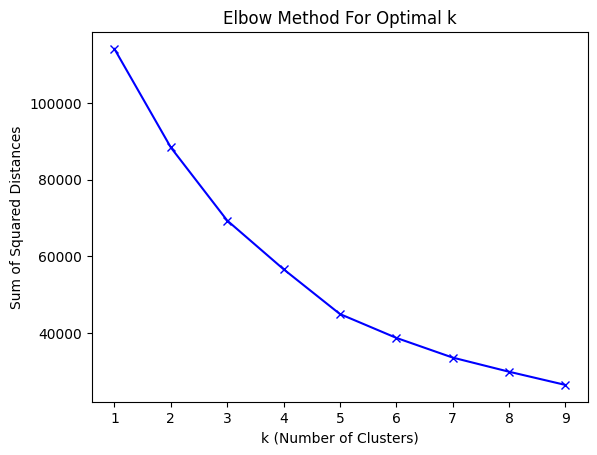

In [27]:
# Extracting the relevant features
features = accidents_df[['closeness_centrality', 'betweenness_centrality', 'degree_centrality', 'accidents_per_node']]

# Normalizing the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Calculating the sum of squared distances for different numbers of clusters (k)
sum_of_squared_distances = []
K = range(1, 10)  # Adjust the range as needed
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(features_scaled)
    sum_of_squared_distances.append(km.inertia_)

# Plotting the "elbow" graph
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k (Number of Clusters)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [28]:
# Set node_id as the index for centrality_df
accidents_df.set_index('node_id', inplace=True)


kmeans = KMeans(n_clusters=5)
accidents_df['kmeans_cluster'] = kmeans.fit_predict(features_scaled)

# Define a custom set of distinct and brighter colors
custom_colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6']
num_clusters = kmeans.n_clusters
selected_colors = custom_colors[:num_clusters]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


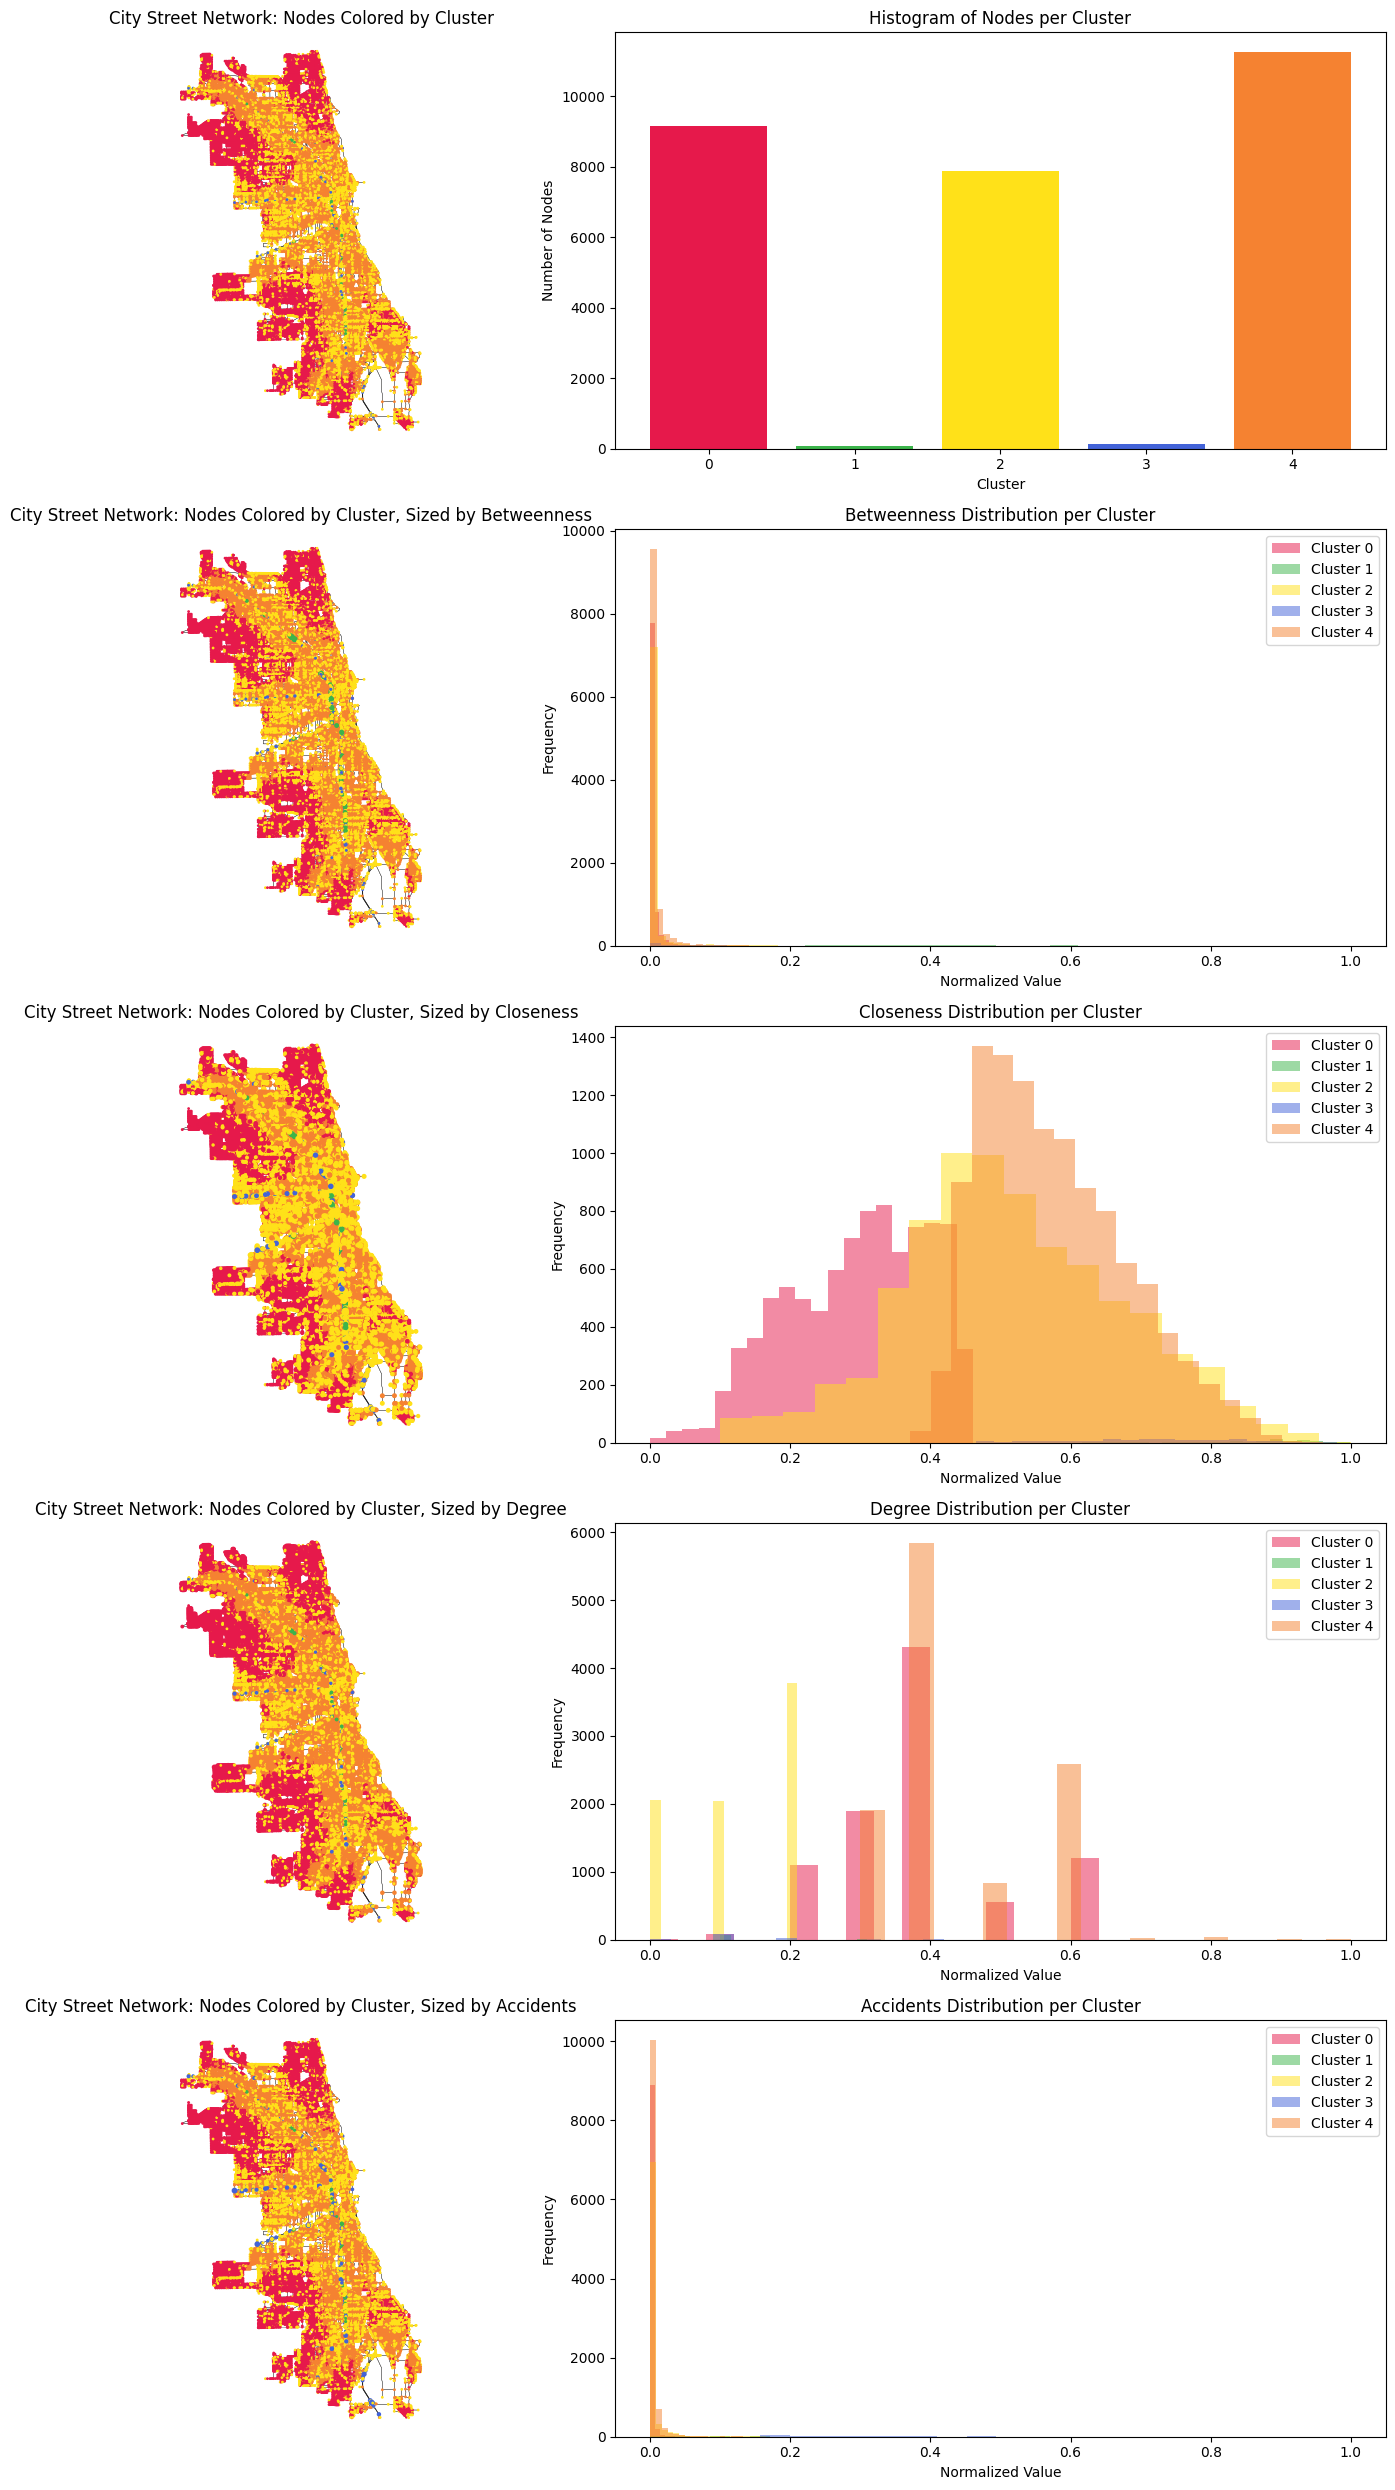

In [29]:
# Normalize each centrality measure and 'accidents_per_node'
measures_norm = ['betweenness_centrality_norm', 'closeness_centrality_norm', 'degree_centrality_norm', 'accidents_per_node_norm']
for measure in measures_norm:
    accidents_df[measure] = (accidents_df[measure.split('_norm')[0]] - accidents_df[measure.split('_norm')[0]].min()) / (accidents_df[measure.split('_norm')[0]].max() - accidents_df[measure.split('_norm')[0]].min())

# Create a 5x2 grid for subplots
fig, axes = plt.subplots(5, 2, figsize=(15, 25))

# Map the cluster assignments to custom colors
node_colors = [selected_colors[accidents_df.loc[node, 'kmeans_cluster']] if node in accidents_df.index else 'gray' for node in scG.nodes()]

# First row: Network graph colored by cluster
edges_gdf = ox.graph_to_gdfs(scG, nodes=False, edges=True, node_geometry=False, fill_edge_geometry=True)
edges_gdf.plot(ax=axes[0, 0], linewidth=0.2, edgecolor='black')
nx.draw_networkx_nodes(scG, pos, node_color=node_colors, node_size=1, ax=axes[0, 0])
axes[0, 0].set_axis_off()
axes[0, 0].set_title("City Street Network: Nodes Colored by Cluster")

# Histogram of nodes per cluster
cluster_counts = accidents_df['kmeans_cluster'].value_counts().sort_index()
axes[0, 1].bar(cluster_counts.index, cluster_counts, color=selected_colors[:len(cluster_counts)])
axes[0, 1].set_title('Histogram of Nodes per Cluster')
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Number of Nodes')

# Subsequent rows: Network graphs colored by cluster and histograms of measure distribution
for i, measure_norm in enumerate(measures_norm):
    # Network graph
    node_sizes = 10 * accidents_df[measure_norm] + 1  # Adjust size as needed
    edges_gdf.plot(ax=axes[i + 1, 0], linewidth=0.2, edgecolor='black')
    nx.draw_networkx_nodes(scG, pos, node_color=node_colors, node_size=node_sizes, ax=axes[i + 1, 0])
    axes[i + 1, 0].set_axis_off()
    axes[i + 1, 0].set_title(f"City Street Network: Nodes Colored by Cluster, Sized by {measure_norm.split('_')[0].title()}")

    # Histogram of measure distribution per cluster
    for cluster in range(num_clusters):
        cluster_data = accidents_df[accidents_df['kmeans_cluster'] == cluster][measure_norm]
        axes[i + 1, 1].hist(cluster_data, bins=20, color=selected_colors[cluster], alpha=0.5, label=f'Cluster {cluster}')
    axes[i + 1, 1].set_title(f'{measure_norm.split("_")[0].title()} Distribution per Cluster')
    axes[i + 1, 1].set_xlabel('Normalized Value')
    axes[i + 1, 1].set_ylabel('Frequency')
    axes[i + 1, 1].legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

## correlation study

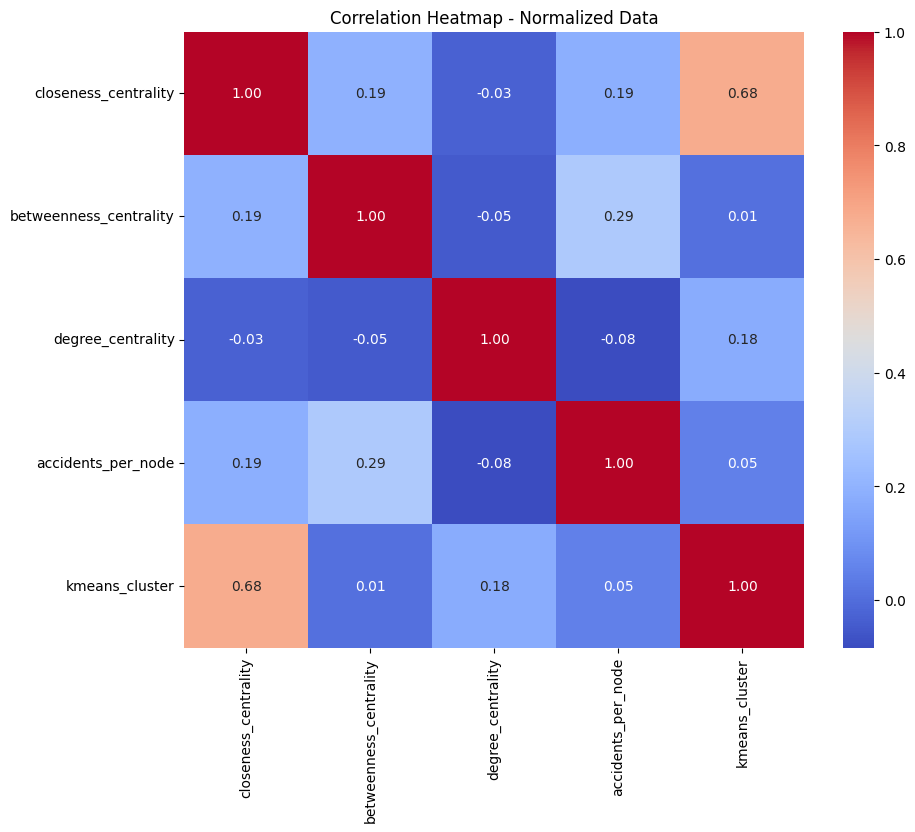

In [30]:
# Normalized Data
normalized_data = accidents_df[['closeness_centrality', 'betweenness_centrality', 'degree_centrality', 'accidents_per_node','kmeans_cluster']]
correlation_normalized = normalized_data.corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_normalized, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap - Normalized Data')
plt.show()
